In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle

#importamos librerias

import sys
sys.path.append('../src/CTA-data-analisis-library/')
import os 
import subprocess
from datetime import datetime
import numpy as np 
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import psutil
import re
import random
import shutil
import pickle
from numba import cuda
import gc
from sklearn.metrics import confusion_matrix

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models

In [3]:
aux1=[]
aux3=[]
for i in range(1,8):
    with open(f"../modelos/performances/006_history_modelo_filtro_0_en_boostrap_stage_{i}.pickle","rb") as fil:
        hist=pickle.load(fil)
        aux1.append(hist["loss"])
        aux3.append(hist["val_loss"])

In [4]:
aux2=[j for i in aux1 for j in i]
aux4=[j for i in aux3 for j in i]



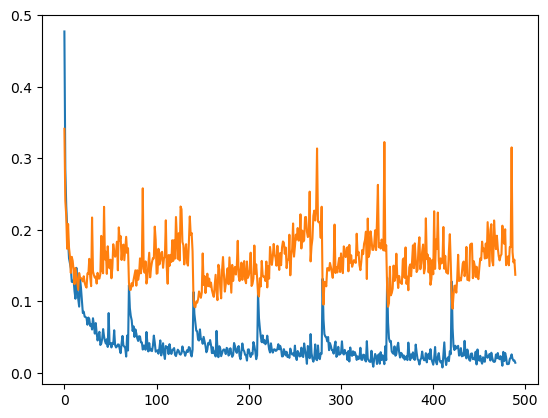

In [5]:
plt.plot(aux2)
plt.plot(aux4)


In [6]:
def runs_disponibles(npy_dir,elements):
    lista=[]
    for i in elements:
        npy_element_dir=os.path.join(npy_dir,"npy_"+i)
        runs=[int(re.search("run_([0-9]{3})_0\.npy",i).group(1)) for i in os.listdir(npy_element_dir) if re.search("run_([0-9]{3})_0\.npy",i)]
        lista.append(runs)
    return lista


def new_create_main_list_runs(number_runs_per_element,posibles_runs):
    #esto es aleatorio por defecto, porque es lo unico que necesito por ahora    
    final=[]
    for ind,lista_runs_element in enumerate(posibles_runs):
        final.append(random.sample(lista_runs_element,number_runs_per_element[ind]))
    return final

#tenemos que hacer un ligero cambio porque se estan cargando con los ejes cambiados
def cambiar_ejes_lista(lista):
    for i,j in enumerate(lista):
        lista[i]=np.swapaxes(j,1,2)
    return lista


#funcion que nos ayuda a mostar la matrix de confusion, needs seaborn as sns
def print_conf_matrix(matrix,elements=None,sin_diag=True,save_dir=None):
    if elements is None:
        elements=['gamma', 'electron',"hadrons"]#, 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    plt.figure(figsize=(13,9))
    sns.heatmap(matrix,annot=True,annot_kws={'size':16})

    plt.yticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=25);
    plt.xticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=25);
    plt.title("True label in Y-axis, predicted label in X-axis", fontsize=15)
    if save_dir != None:
        plt.tight_layout()
        plt.savefig(save_dir)


def comp_and_diplay_conf_matrix(y_test,y_predict,elements=None,sin_diag=True,norm="true",save_dir=None):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1),normalize=norm)
    print_conf_matrix(matrix,elements=elements,sin_diag=sin_diag,save_dir=save_dir)




In [7]:
#enviroment variables
npy_final_dir="../datos/elementos_npy_test"
base_dir_elementos="../datos/elementos"
elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

In [8]:
#hacemos esto porque dan problemas las runs 2 y 3 para gamma por no tener correspondiente txt
chose_runs=runs_disponibles(npy_final_dir,elements)

In [9]:

list_runs=new_create_main_list_runs([1,5,2,2,2,2,2],chose_runs)

x_train_list,x_test_list,y_train_list,y_test_list=loaddata4use.load_dataset_completo(npy_final_dir,labels_asign=[0,1,2,2,2,2,2],elements=elements,
                                                                                            main_list_runs=list_runs,pre_name_folders="npy_",telescopes=[1,2,3,4],
                                                                                            test_size=0.05,same_quant="equal",verbose=True,fill=True,categorical=True)
x_train_list=cambiar_ejes_lista(x_train_list)
x_test_list=cambiar_ejes_lista(x_test_list)


Load of names and common events
_______________
0 ;  Element:  gamma  , Runs:  [19]  Shape of common events (tels,common events):  (4, 1158)
0 ;  Element:  electron  , Runs:  [157, 97, 102, 101, 49]  Shape of common events (tels,common events):  (4, 248)
1 ;  Element:  electron  , Runs:  [157, 97, 102, 101, 49]  Shape of common events (tels,common events):  (4, 236)
2 ;  Element:  electron  , Runs:  [157, 97, 102, 101, 49]  Shape of common events (tels,common events):  (4, 253)
3 ;  Element:  electron  , Runs:  [157, 97, 102, 101, 49]  Shape of common events (tels,common events):  (4, 239)
4 ;  Element:  electron  , Runs:  [157, 97, 102, 101, 49]  Shape of common events (tels,common events):  (4, 247)
0 ;  Element:  proton  , Runs:  [151, 63]  Shape of common events (tels,common events):  (4, 177)
1 ;  Element:  proton  , Runs:  [151, 63]  Shape of common events (tels,common events):  (4, 146)
0 ;  Element:  helium  , Runs:  [124, 83]  Shape of common events (tels,common events):  (4, 

In [ ]:
#cargamos el ultimo modelo de los dos filtros:
modelos=[tf.keras.models.load_model(name) for name in glob.glob("../modelos/006_modelo_filtro_*_en_boostrap_stage_10.h5")]


2023-01-20 16:26:04.767649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 16:26:04.769124: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
y_pred_all=[]
total_len=x_train_list[1].shape[0]
n=200
cicles=int(np.ceil(total_len/n))
for i in range(cicles):
    print(i)
    if (n*i+n)>=total_len:
        final=total_len
    else:
        final=n*i+n

    x_aux=[ x[(n*i):final,:,:,:] for x in x_train_list]
    print(x_aux[0].shape)
    y_pred=[model(x_aux).numpy() for model in modelos]
    if i==0:
        y_pred_all=y_pred
    else:
        for j in range(len(y_pred_all)):
            print(j)
            y_pred_all[j]=np.concatenate([y_pred_all[j],y_pred[j]],axis=0)

0
(200, 55, 93, 1)
1
(200, 55, 93, 1)
0
1
2
3
4
2
(200, 55, 93, 1)
0
1
2
3
4
3
(200, 55, 93, 1)
0
1
2
3
4
4
(200, 55, 93, 1)
0
1
2
3
4
5
(200, 55, 93, 1)
0
1
2
3
4
6
(200, 55, 93, 1)
0
1
2
3
4
7
(200, 55, 93, 1)
0
1
2
3
4
8
(200, 55, 93, 1)
0
1
2
3
4
9
(200, 55, 93, 1)
0
1
2
3
4
10
(200, 55, 93, 1)
0
1
2
3
4
11
(200, 55, 93, 1)
0
1
2
3
4
12
(200, 55, 93, 1)
0
1
2
3
4
13
(200, 55, 93, 1)
0
1
2
3
4
14
(200, 55, 93, 1)
0
1
2
3
4
15
(200, 55, 93, 1)
0
1
2
3
4
16
(200, 55, 93, 1)
0
1
2
3
4
17
(200, 55, 93, 1)
0
1
2
3
4
18
(200, 55, 93, 1)
0
1
2
3
4
19
(200, 55, 93, 1)
0
1
2
3
4
20
(200, 55, 93, 1)
0
1
2
3
4
21
(50, 55, 93, 1)
0
1
2
3
4


In [ ]:
for i in y_pred_all:
    print(i.shape)

(4250, 3)
(4250, 3)
(4250, 3)
(4250, 3)
(4250, 3)


0
1
2
3
4


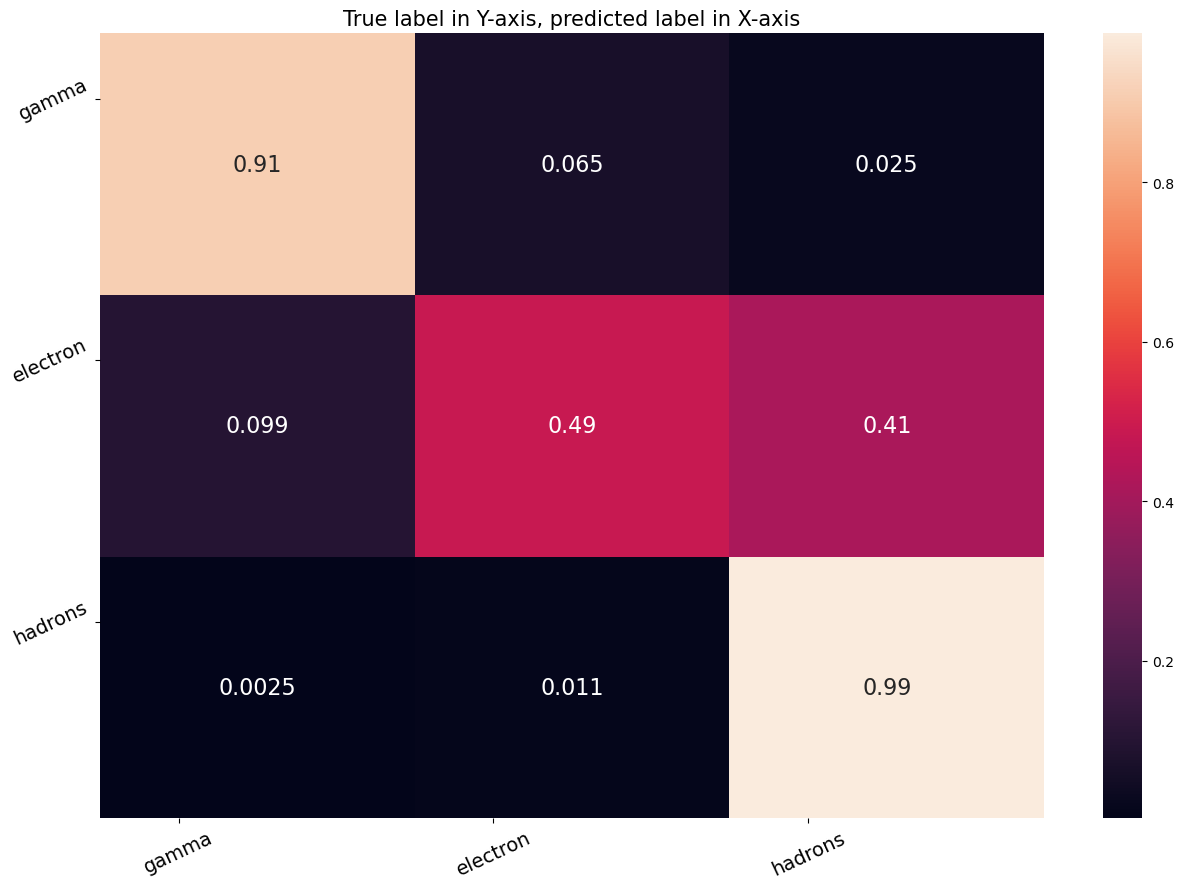

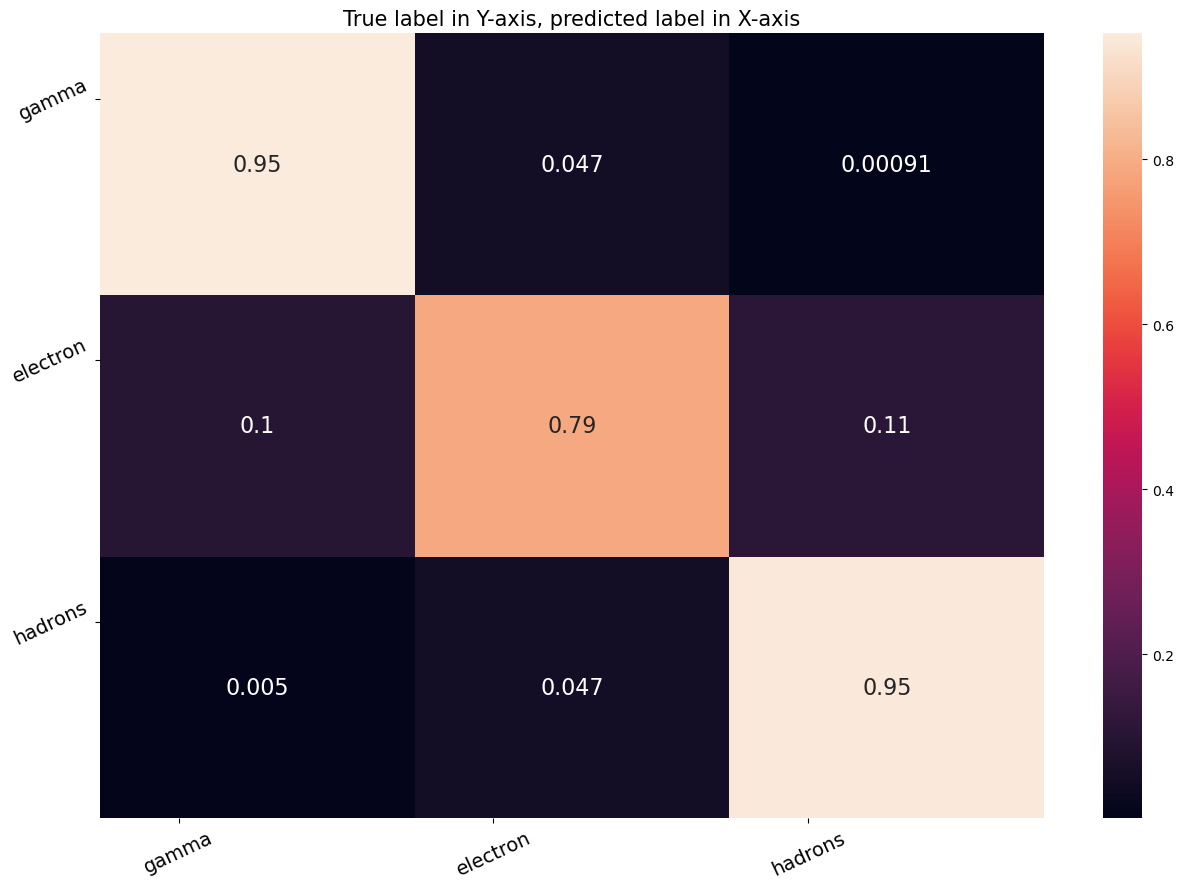

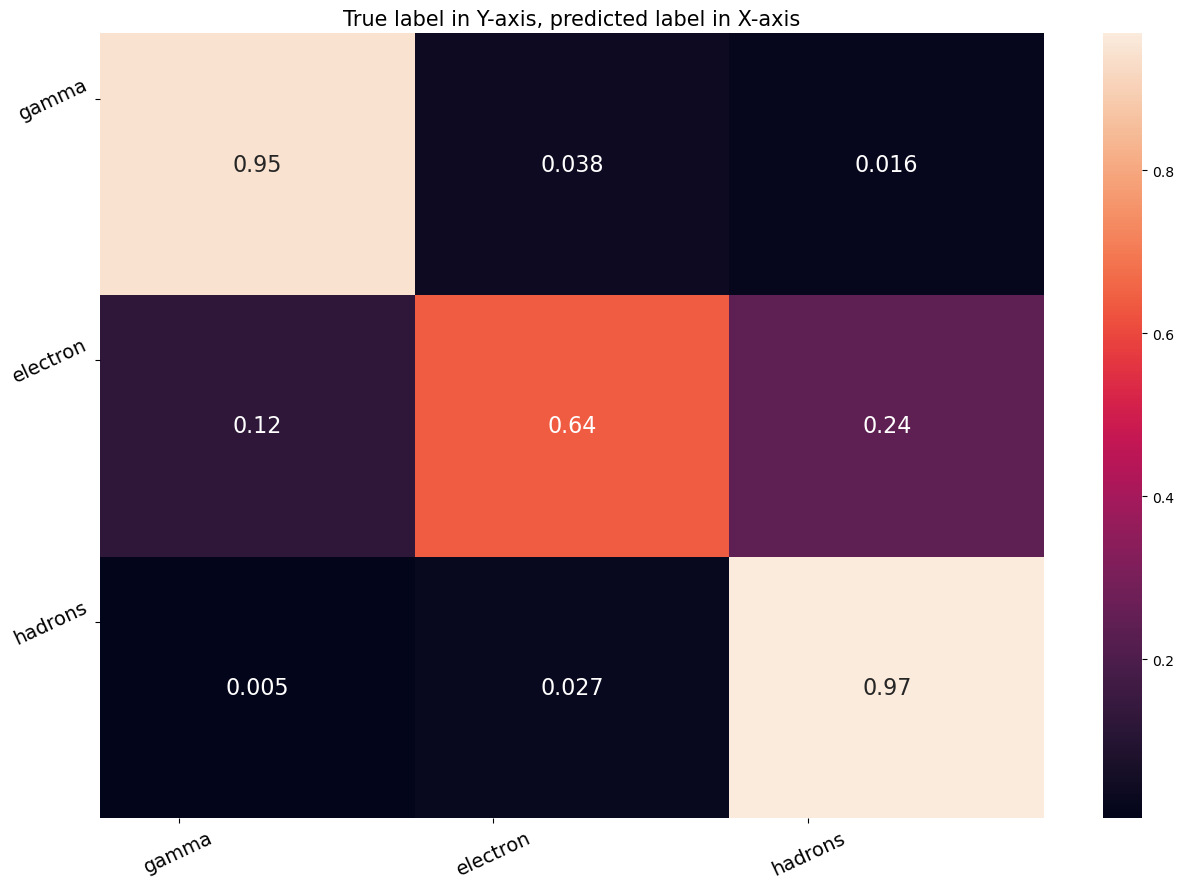

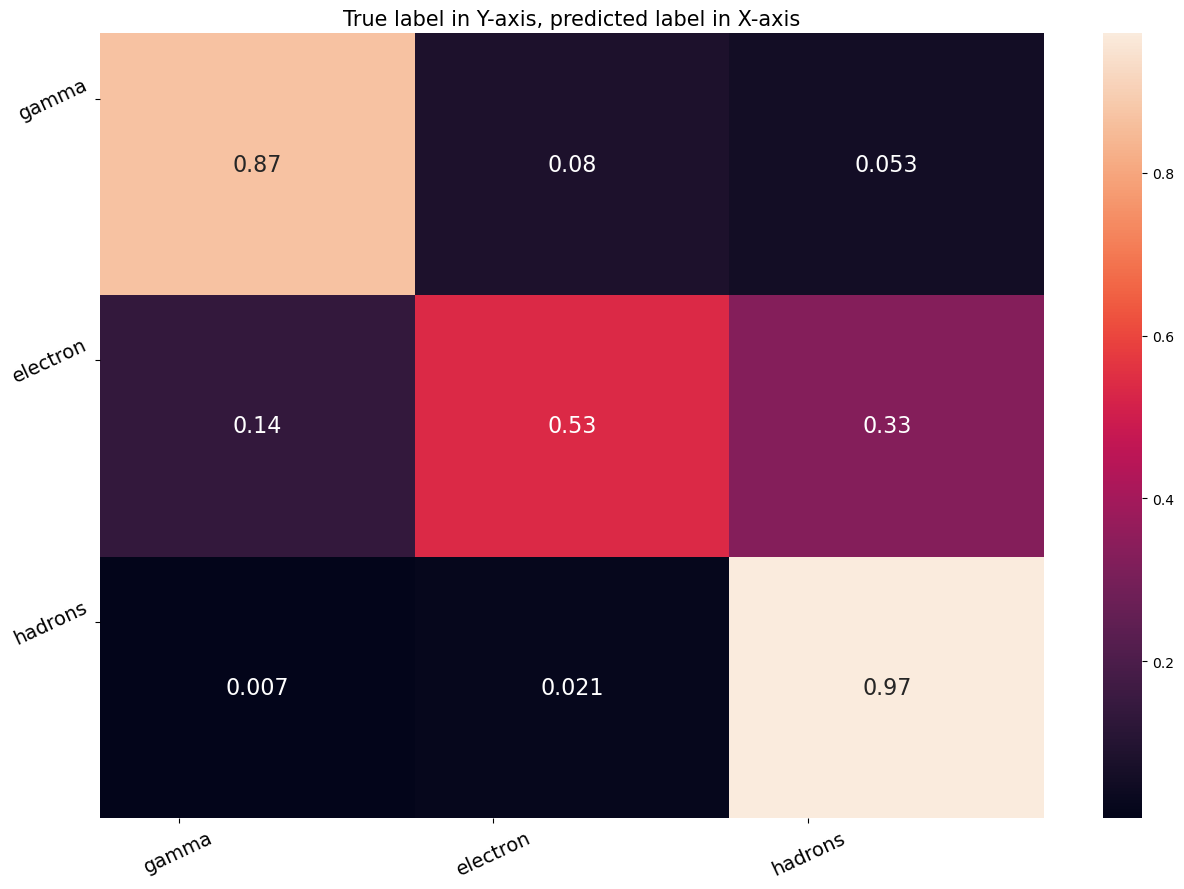

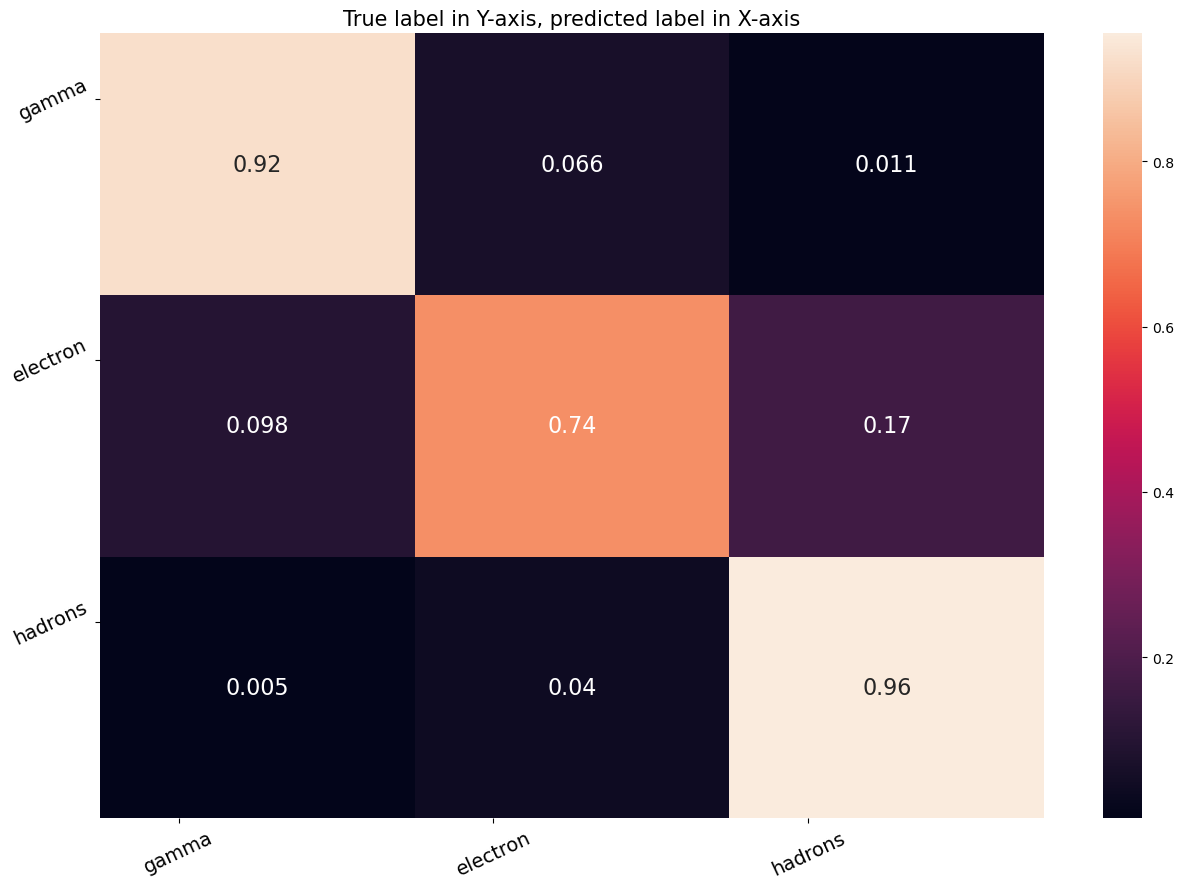

In [ ]:
for i , model in enumerate(modelos):
    print(i)
    #cargamos el modelo y lo pasamos por los datos
    fig=comp_and_diplay_conf_matrix(y_train_list,y_pred_all[i],sin_diag=False,norm="true",save_dir=f"../results/006_confMatrix_model_{i}_Norm.png")